In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

In [357]:
df_features = pd.read_csv("df_features.csv")
df_features.head()

,BuildingType,PrimaryPropertyType,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,GHGEmissionsIntensity,Building_Age,Emissions_per_Surface,Energy_per_Surface,GFA-1use_ratio,GFA_per_Floor,Emissions_per_floor,Energy_per_floor,Elec_ratio,steam_ratio,NGas_ratio,District
0,NonResidential,Other,12,88434,0,60.0,2.83,89,0.00,81.71,1.00,7369.50,20.83,602196.88,0.55,0.28,0.18,CENTRAL CITY
1,NonResidential,Other,10,61320,0,56.0,4.67,90,0.00,110.81,1.00,6132.00,28.64,679458.40,0.41,0.33,0.27,CENTRAL CITY
2,NonResidential,Other,11,83008,0,27.0,2.12,90,0.00,69.38,0.98,7546.18,16.01,523526.82,0.49,0.00,0.51,CENTRAL CITY
3,NonResidential,Other,8,102761,0,0.0,2.16,90,0.00,61.29,1.00,12845.12,27.69,787266.44,0.58,0.36,0.06,CENTRAL CITY
4,NonResidential,Other,9,65009,0,48.0,5.05,88,0.01,101.46,1.00,7223.22,36.47,732895.28,0.20,0.25,0.55,CENTRAL CITY


In [359]:
df_Energy = pd.read_csv("EnergyUse_target")
df_Energy.head()

,SiteEnergyUse(kBtu)
0,7226362.5
1,6794584.0
2,5758795.0
3,6298131.5
4,6596057.5


In [361]:
df_Energy= df_Energy.values
df_Energy

array([[7226362.5 ],
       [6794584.  ],
       [5758795.  ],
       ...,
       [5765898.  ],
       [ 719471.19],
       [1152896.25]])

In [363]:
X = df_features

y = df_Energy.ravel()

# Séparation pour la cible y (EnergyUse)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=11)

In [365]:
# Définir les colonnes par type pour séparer les traitements dans les pipelines : notamment encodage.

categorical_cols = ['BuildingType', 'PrimaryPropertyType', 'District']

numerical_cols = ['NumberofFloors',
    'PropertyGFATotal', 'PropertyGFAParking',
    'GHGEmissionsIntensity', 'Building_Age','ENERGYSTARScore',
    'Emissions_per_Surface','Energy_per_Surface', 'GFA-1use_ratio', 'GFA_per_Floor',
    'Emissions_per_floor','Energy_per_floor', 'Elec_ratio', 'steam_ratio', 'NGas_ratio']

In [367]:
# appliquer les pipelines : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
# on définit l'ensemble des transaformations qu'on veut faire sur nos données / colonnes à travers des pipelines : 

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # je remplace les val manquantes si y en a par la moyenne
    ('scaler', StandardScaler()) ]) # je strandardise les chiffres sur une même échelle.
                                    #centrer les données sur 0 et/ou les ramener à un écart-type de 1

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # je remplace les valeurs manquantes par la valeur la plus fréquente.
    ('onehot', OneHotEncoder(handle_unknown='ignore')) ]) # j'encode avec OneHotEncoder

In [369]:

# Avec Columns Transformer, on vient appliquer à chaque colonne, ce qu'on a défini dans les pipelines.

col_trans = ColumnTransformer([('num', numeric_pipe, numerical_cols),
                               ('cat', categorical_pipe, categorical_cols)])

In [371]:
# je selectionne mon modèle : 
reg = LinearRegression()

# on crée un nouveau pipeline qui va permettre de faire 2 choses à la fois : 
    #traiter  les données selon ce qu'on a défini dans ColumnTransformer et les pipes, 
    #puis il va entrainer le modèle selon le modèle qu'on choisit ( reg)  : 

pipeline_energy = Pipeline([ ('preprocessing', col_trans), ('regressor', reg)])

# definition du scoring : 

scoring = {'rmse': 'neg_root_mean_squared_error',
           'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}
 
# Je fais une validation croisée sur le jeu d'entraînement, pour tester sur plusieurs sous-parties du jeu d'entraînement.
# cela permet d'évaluer mon modèle de manière robuste, sans dépendre d'une unique division train/val.
# Cela permet aussi d'évaluer la capacité du modèle à généraliser, avant de le tester sur le jeu de test qui est mis de côté.

cv_results_energy = cross_validate(pipeline_energy, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

print('cv_results_energy : ')
display(cv_results_energy)
print('------------------------------------------')

#Résultats de la validation croisée : Energy
print("\n Résultats validation croisée - EnergyUse:")
print("Train R²:", np.mean(cv_results_energy['train_r2']))
print("Test R²:", np.mean(cv_results_energy['test_r2']))
print("Test MAE:", -np.mean(cv_results_energy['test_mae']))
print("Test RMSE:", -np.mean(cv_results_energy['test_rmse']))

print('prenons en considération que MAE et RMSE sont positive malgré que ça ressort en négatif à cause du cross validate,on ajoute (-)')

print("\nmon modèle de validation croisée explique 87.79 % de la variance dans les données d'entraînement ;c'est une bonne capacité à apprendre des données.")

print('\nLe modèle explique 75,49 % de la variance sur des données jamais vues  ; ça reste un bon score même si c est plus bas que R2 train')

cv_results_energy : 


{'fit_time': array([0.03307009, 0.00489497, 0.0032649 , 0.00318122, 0.00328708]),
 'score_time': array([0.00434303, 0.00146294, 0.00122714, 0.00145292, 0.00126314]),
 'test_rmse': array([ -684079.74201118,  -687586.56736624,  -637775.54666183,
         -564730.47393709, -1424111.41192411]),
 'train_rmse': array([-598856.49425185, -596490.47292097, -609214.94478056,
        -625421.09271647, -588813.12137182]),
 'test_mae': array([-412435.15504856, -386633.55680851, -433869.87340848,
        -383386.60896514, -473731.80195686]),
 'train_mae': array([-384516.62606593, -382574.81555851, -374323.09316566,
        -389826.82347134, -372388.16104455]),
 'test_r2': array([0.82821691, 0.84220755, 0.87645103, 0.8868794 , 0.3408666 ]),
 'train_r2': array([0.88249314, 0.88088817, 0.8724255 , 0.87085928, 0.88307762])}

------------------------------------------

 Résultats validation croisée - EnergyUse:
Train R²: 0.8779487428797722
Test R²: 0.7549242982925118
Test MAE: 418011.3992375098
Test RMSE: 799656.7483800899
prenons en considération que MAE et RMSE sont positive malgré que ça ressort en négatif à cause du cross validate,on ajoute (-)

mon modèle de validation croisée explique 87.79 % de la variance dans les données d'entraînement ;c'est une bonne capacité à apprendre des données.

Le modèle explique 75,49 % de la variance sur des données jamais vues  ; ça reste un bon score même si c est plus bas que R2 train


In [373]:
# Entraînement sur X_train : 

pipeline_energy.fit(X_train, y_train)


#  Prédictions : 
y_train_pred = pipeline_energy.predict(X_train)
y_test_pred = pipeline_energy.predict(X_test)


#  Évaluation - Energy
print("\n Évaluation finale - EnergyUse avec Linear Regression: ")
print("R2 train:", r2_score(y_train, y_train_pred))
print("R2 test:", r2_score(y_test, y_test_pred))
print("RMSE train:", mean_squared_error(y_train, y_train_pred, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred))
print("MAE test:", mean_absolute_error(y_test, y_test_pred))


 Évaluation finale - EnergyUse avec Linear Regression: 
R2 train: 0.874243373215156
R2 test: 0.8700969366293558
RMSE train: 613089.0272524621
RMSE test: 643085.4626427263
MAE train: 384708.57144680846
MAE test: 434238.3277542373


Train R2 = 0.874, donc le modèle explique 87.4 % de la variance dans les données d entrainement

Test R2 = 0.870 : Il explique 87 % de la variance sur le jeu de test.

Mon modèle généralise bien, train R2 et test R2 sont élevés et proches prsques similaires

Les résultats de RMSE et MAE train et test restent proches, ce qui va dans le même sens que R2, le modèle apparait bon et stable

In [375]:
# on fait la même chose pour DummyRegressor : 

dummy_reg = DummyRegressor(strategy='mean')

# creation de pipeline : 
pipeline_energy_dummy = Pipeline([('preprocessing', col_trans), ('regressor', dummy_reg)])


# validation croisée : 
cv_results_energy_dummy = cross_validate(pipeline_energy_dummy, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)


print("\nDummy Regressor - EnergyUse CROSS VALIDATION : ")
print("Test R²:", np.mean(cv_results_energy_dummy['test_r2']))
print("Test RMSE:", -np.mean(cv_results_energy_dummy['test_rmse']))
print("Test MAE:", -np.mean(cv_results_energy_dummy['test_mae']))


# entrainement : 

pipeline_energy_dummy.fit(X_train, y_train)


#  Prédictions : 
y_train_pred_dummy = pipeline_energy_dummy.predict(X_train)
y_test_pred_dummy = pipeline_energy_dummy.predict(X_test)



#  Évaluation - Energy
print("\n Évaluation finale - EnergyUse avec Dummy: ")
print("R2 train:", r2_score(y_train, y_train_pred_dummy))
print("R2 test:", r2_score(y_test, y_test_pred_dummy))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_dummy, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_dummy, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_dummy))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_dummy))


Dummy Regressor - EnergyUse CROSS VALIDATION : 
Test R²: -0.003762573651739709
Test RMSE: 1729059.7777208164
Test MAE: 1383123.2514820336

 Évaluation finale - EnergyUse avec Dummy: 
R2 train: 0.0
R2 test: -0.00018934727046127087
RMSE train: 1728853.1422411709
RMSE test: 1784432.4330212336
MAE train: 1382767.8723430512
MAE test: 1460410.5129096648


Dummy is Dumb indeed lol ! 
Dummy n’apprend rien de la cross validation entrainement R2 = 0 ni au modèle ! 
Le modèle ne comprend pas la relation entre les variables explicatives et les targets R2 nulles, ou nég, RMSE ET MAE grandes.


In [377]:
# on fait la même chose pour SVR : 

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1) 

# creation de pipeline :

pipeline_energy_svr = Pipeline([('preprocessing', col_trans), ('regressor', svr)])


# validation croisée : 
cv_results_energy_svr= cross_validate(pipeline_energy_svr, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)


print("\n SVR - EnergyUse CROSS VALIDATION : ")
print("Test R²:", np.mean(cv_results_energy_svr['test_r2']))
print("Test RMSE:", -np.mean(cv_results_energy_svr['test_rmse']))
print("Test MAE:", -np.mean(cv_results_energy_svr['test_mae']))


# entrainement : 

pipeline_energy_svr.fit(X_train, y_train)


#  Prédictions : 
y_train_pred_svr = pipeline_energy_svr.predict(X_train)
y_test_pred_svr = pipeline_energy_svr.predict(X_test)

#  Évaluation - Energy
print("\n Évaluation finale - EnergyUse avec SVR : ")
print("R2 train:", r2_score(y_train, y_train_pred_svr))
print("R2 test:", r2_score(y_test, y_test_pred_svr))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_svr, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_svr, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_svr))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_svr))


 SVR - EnergyUse CROSS VALIDATION : 
Test R²: -0.09592510737136131
Test RMSE: 1807334.690390449
Test MAE: 1316089.753131175

 Évaluation finale - EnergyUse avec SVR : 
R2 train: -0.0962336517150193
R2 test: -0.09881038467473968
RMSE train: 1810129.5928182767
RMSE test: 1870339.1879740695
MAE train: 1314145.0490185313
MAE test: 1382767.6529201965


Le modèle SVR n'est pas du tout performant dans ce cas. il n'arrive pas à modéliser les relations entre les variables.
Il n'est peut être pas adapté à ce jeu de données ou nécessite des étapes de traitement supplémentaires...

In [379]:
# on fait la même chose pour RandomForestRegressor : 

rf = RandomForestRegressor(n_estimators=10, random_state=42)

# creation de pipeline :

pipeline_energy_rf = Pipeline([('preprocessing', col_trans), ('regressor', rf)])


# validation croisée : 
cv_results_energy_rf= cross_validate(pipeline_energy_rf, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)


print("\n RandomForest Regressor - EnergyUse CROSS VALIDATION : ")
print("Test R²:", np.mean(cv_results_energy_rf['test_r2']))
print("Test RMSE:", -np.mean(cv_results_energy_rf['test_rmse']))
print("Test MAE:", -np.mean(cv_results_energy_rf['test_mae']))


# entrainement : 

pipeline_energy_rf.fit(X_train, y_train)


#  Prédictions : 
y_train_pred_rf = pipeline_energy_rf.predict(X_train)
y_test_pred_rf = pipeline_energy_rf.predict(X_test)



#  Évaluation - Energy
print("\n Évaluation finale - EnergyUse avec Random Forest: ")
print("R2 train:", r2_score(y_train, y_train_pred_rf))
print("R2 test:", r2_score(y_test, y_test_pred_rf))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_rf, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_rf, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_rf))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_rf))


 RandomForest Regressor - EnergyUse CROSS VALIDATION : 
Test R²: 0.9671180709411399
Test RMSE: 310733.64066101104
Test MAE: 160547.61827765958

 Évaluation finale - EnergyUse avec Random Forest: 
R2 train: 0.9927020662827148
R2 test: 0.9724025223717916
RMSE train: 147692.37044380602
RMSE test: 296410.5729260211
MAE train: 69385.41696170211
MAE test: 159591.0134279661


Le modèle Random Forest donne globalement des bons résultats : 

Le R2 est de 99% pour train et 97% pour test : le modèle apprend super bien des données et dispose d'une bonne performance de prédiction.

Les erreurs restent stables entre la validation croisée et le scoring finale ce qui confirme la stabilité du modèle, malgré que ce soit grand.

mais la différence entre les résultats train et test de RMSE et MAE montrent qu'il y a un petit surapprentissage.


In [381]:
from sklearn.model_selection import GridSearchCV
# Je fais GrisSearch pour optimiser les paramètres du modèle Random Forest
# Je définis la grille d'hyperparamètres : 

param_grid = {'regressor__n_estimators': [50, 100],
              'regressor__max_depth': [5,10, 20, None],
              'regressor__max_features': [10,'sqrt', 'log2', None] }

# j'applique GridSearch avec validation croisée :

grid_search = GridSearchCV( pipeline_energy_rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1 )
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'GHGEmissionsIntensity',
                                                                          'Building_Age',
                                                                          'ENERGYSTARScore',
                                                                          'Emissions_per_Surface',
                                                                          'Energy_per_Surface',
                                                                          'GFA-1use_ratio'...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'District'])])),
                                       ('regressor',
                                        RandomForestRegressor(n_estimators=10,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, 20, None],
                         'regressor__max_features': [10, 'sqrt', 'log2', None],
                         'regressor__n_estimators': [50, 100]},
             scoring='r2', verbose=1)

In [383]:
# je fais le fit sur train pour obtenir les meilleurs hyperparamètres : 

grid_search.fit(X_train, y_train)

# j'obtiens les meilleurs hyperparamètres pour mon modèle :

print("\n Voici les meilleurs hyperparamètres :")

print(grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

 Voici les meilleurs hyperparamètres :
{'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__n_estimators': 100}


In [384]:
print("Voici le meilleur score R² pour la validation croisée GridSearch :", grid_search.best_score_)

Voici le meilleur score R² pour la validation croisée GridSearch : 0.9735933747151764


In [387]:
print(grid_search.best_estimator_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'GHGEmissionsIntensity',
                                                   'Building_Age',
                                                   'ENERGYSTARScore',
                                                   'Emissions_per_Surface',
                                                   'Energy_per_Surface',
      

In [389]:
# on va appliquer (grid_search.best_estimator_) pour générer nos prédictions : 

y_train_pred_gridsearch = grid_search.best_estimator_.predict(X_train)
y_test_pred_gridsearch = grid_search.best_estimator_.predict(X_test)

In [391]:
#  on obtient nos résultats de scoring avec Grid Search : 

print("\n Évaluation finale - ENERGY avec Grid Search: ")
print("R2 train:", r2_score(y_train, y_train_pred_gridsearch ))
print("R2 test:", r2_score(y_test, y_test_pred_gridsearch))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_gridsearch , squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_gridsearch, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_gridsearch ))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_gridsearch))


 Évaluation finale - ENERGY avec Grid Search: 
R2 train: 0.9961265060047929
R2 test: 0.9763699940881378
RMSE train: 107599.32506114134
RMSE test: 274277.9602062758
MAE train: 48607.59566918146
MAE test: 136508.66322234037


In [393]:
# COMPARAISON DE SCORING ENTRE MODELE RANDOM FOREST ET RANDOM FOREST OPTIMISE AVEC GRID SEARCH

#  Évaluation - ENERGY
print("\n Évaluation finale - ENERGYUse avec Grid Search: ")
print("R2 train:", r2_score(y_train, y_train_pred_gridsearch ))
print("R2 test:", r2_score(y_test, y_test_pred_gridsearch))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_gridsearch , squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_gridsearch, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_gridsearch ))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_gridsearch))


#  Évaluation - Energy
print("\n Évaluation finale - EnergyUse avec Random Forest: ")
print("R2 train:", r2_score(y_train, y_train_pred_rf))
print("R2 test:", r2_score(y_test, y_test_pred_rf))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_rf, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_rf, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_rf))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_rf))


 Évaluation finale - ENERGYUse avec Grid Search: 
R2 train: 0.9961265060047929
R2 test: 0.9763699940881378
RMSE train: 107599.32506114134
RMSE test: 274277.9602062758
MAE train: 48607.59566918146
MAE test: 136508.66322234037

 Évaluation finale - EnergyUse avec Random Forest: 
R2 train: 0.9927020662827148
R2 test: 0.9724025223717916
RMSE train: 147692.37044380602
RMSE test: 296410.5729260211
MAE train: 69385.41696170211
MAE test: 159591.0134279661


Le modèle optimisé avec GridSearch explique plus de 97,6 % de la variance sur le jeu de test, ceci atteste de son excellente capacité prédictive. c'est légèrement meilleur que le modèle non optimisé 97,2 %

Les erreurs (RMSE/MAE) sur le test sont relativement faibles et inférieures à la version non optimisée.
mais la différence entre les erreurs train/test subssiste. cela confirme donc qu'il y a bien un petit surapprentissage.

Le modèle optimisé avec Grid Search obtient de meilleures performances globalement, avec un R² plus élevé et des erreurs plus faibles, mais les résultats restent proches du modèle mon optimisé, qui était déjà un bon modèle dans notre cas.


In [399]:
# Récupération des colonnes après preprocessing

feature_names = grid_search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# Importance des features
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

# Affichage des features avec leur importance : 
feature_importance_Energyuse = pd.DataFrame({'Feature': feature_names,'Importance': importances})
feature_importance_Energyuse.head()

,Feature,Importance
0,num__NumberofFloors,0.045123
1,num__PropertyGFATotal,0.414723
2,num__PropertyGFAParking,0.002312
3,num__GHGEmissionsIntensity,0.002192
4,num__Building_Age,0.002125


In [401]:
# voici le classement des features les plus importantes pour notre modèle : 
feature_importance_Energyuse.sort_values(by='Importance', ascending=False)

,Feature,Importance
7,num__Energy_per_Surface,0.431297
1,num__PropertyGFATotal,0.414723
11,num__Energy_per_floor,0.086231
0,num__NumberofFloors,0.045123
8,num__GFA-1use_ratio,0.002844
10,num__Emissions_per_floor,0.002669
2,num__PropertyGFAParking,0.002312
3,num__GHGEmissionsIntensity,0.002192
4,num__Building_Age,0.002125
9,num__GFA_per_Floor,0.001736


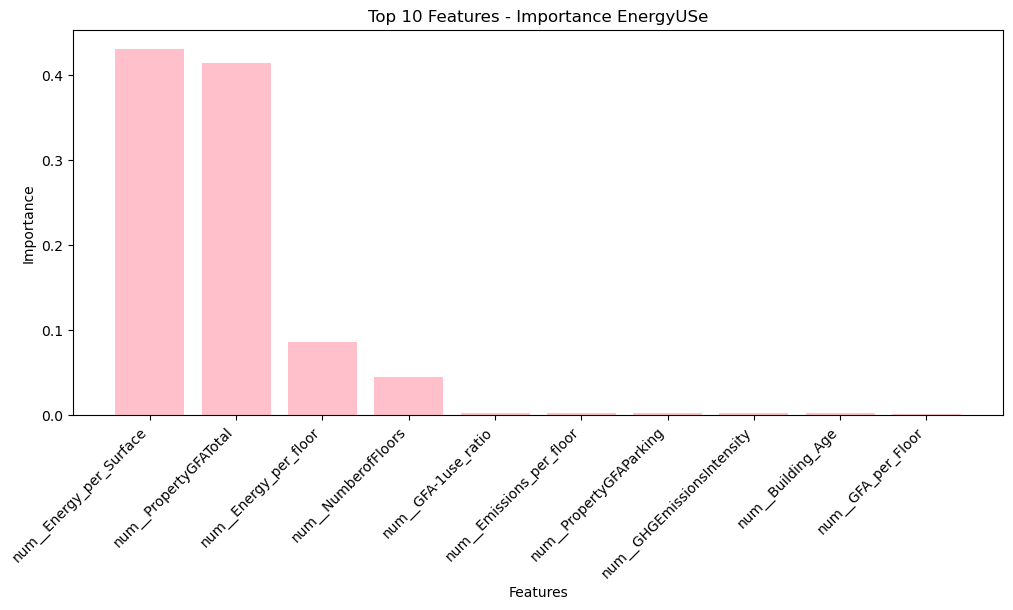

In [405]:
top_features = feature_importance_Energyuse.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 5))
plt.bar(top_features['Feature'], top_features['Importance'], color='pink')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Features - Importance EnergyUSe')
plt.xticks(rotation=45, ha='right')  
plt.show()